In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

Let us start by importing the data and exploring the column names and number of entries.

In [2]:
df_checkin = pd.read_csv("data/processed_dataset.csv")

In [3]:
df_checkin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22809624 entries, 0 to 22809623
Data columns (total 8 columns):
 #   Column      Dtype  
---  ------      -----  
 0   User ID     int64  
 1   Venue ID    object 
 2   day         object 
 3   local time  object 
 4   lat         float64
 5   lon         float64
 6   place       object 
 7   country     object 
dtypes: float64(2), int64(1), object(5)
memory usage: 1.4+ GB


### Ground Truth

Let us create a ground truth dataframe that will contain the homes of users.

We start by isolating the check-ins that have the `Home (private)` label.

In [4]:
df_checkins_homes = df_checkin[df_checkin.place == "Home (private)"]

In [5]:
len(df_checkins_homes)

1724007

We see that we have 1724007 user check-ins into their homes.

There is one issue with the dataset, whch is that the home location may vary certain users. Here, we sort the home check-ins by `User ID` and we see that for user 15, the home longitude and latitude may vary.

In [6]:
df_checkins_homes.sort_values("User ID").head(30)

,User ID,Venue ID,day,local time,lat,lon,place,country
5669330,15,4f9043f2e4b06b50af9c407c,Mon,2012-06-11 01:26:11+00:00,36.289471,-119.342457,Home (private),US
2314342,15,4f9043f2e4b06b50af9c407c,Sat,2012-04-28 13:03:24+00:00,36.289471,-119.342457,Home (private),US
2314343,15,4f9043f2e4b06b50af9c407c,Sun,2012-04-29 11:05:04+00:00,36.289471,-119.342457,Home (private),US
2314344,15,4f9043f2e4b06b50af9c407c,Wed,2012-05-01 23:53:56+00:00,36.289471,-119.342457,Home (private),US
4407361,15,4bcb40170687ef3b2349ddcc,Wed,2012-05-23 16:16:55+00:00,36.298218,-119.272754,Home (private),US
4693116,15,4f9043f2e4b06b50af9c407c,Tue,2012-05-29 13:26:33+00:00,36.289471,-119.342457,Home (private),US
2747619,15,4f9043f2e4b06b50af9c407c,Mon,2012-05-06 23:37:41+00:00,36.289471,-119.342457,Home (private),US
4693115,15,4f9043f2e4b06b50af9c407c,Tue,2012-05-29 00:16:37+00:00,36.289471,-119.342457,Home (private),US
4693114,15,4f9043f2e4b06b50af9c407c,Mon,2012-05-28 00:35:05+00:00,36.289471,-119.342457,Home (private),US
4693113,15,4f9043f2e4b06b50af9c407c,Sun,2012-05-27 10:43:29+00:00,36.289471,-119.342457,Home (private),US


Create dataframe for user home locations, where we use the median location with label home for each user

In [7]:
df_homes = df_checkins_homes.groupby("User ID")[["lat", "lon"]].agg("median")

In [8]:
df_homes

,lat,lon
User ID,,
15,36.289471,-119.342457
19,40.980988,-72.123841
54,39.069125,-117.614146
58,29.933542,-90.098043
75,7.080896,125.615016
...,...,...
2195961,53.206414,50.117447
2197523,36.996848,35.319189
2197569,-6.902254,107.615613


Since the check-in location labeled with `Home (private)` may not be unique for a certain user, we decide to keep only users whose home locations have a standard deviation of 100m around the mean location.

The `haversine` function computes the distance between two point on a sphere using thei longitudes and latitudes.

In [9]:
EARTH_RADIUS = 6371.0088
def haversine(lat1, lat2, lon1, lon2):
    sigma = np.arcsin(np.sqrt(np.sin((lat2-lat1)/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin((lon1-lon2)/2)**2))
    return (2 * EARTH_RADIUS * sigma)

The `select_relevant_homes` filters out the users having home locations with a standard deviation larger than 100m.

In [10]:
def select_relevant_homes(df_homes):
    
    # Grouping df_homes according to the user id and compute std and mean for lat and lon
    df_homes = df_homes.groupby('User ID').agg({'lat':('std','mean'),'lon':('std','mean')})
    
    # Filling nan values with 0 (std return 0 if there is only one sample)
    df_homes.fillna(0,inplace = True)
    
    # Compute distance from mean
    
    # Preparing dataframe
    df_tmp = pd.DataFrame()
    df_tmp['lat1'] = df_homes.lat['mean']-df_homes.lat['std']
    df_tmp['lat2'] = df_homes.lat['mean']+df_homes.lat['std']
    df_tmp['lon1'] = df_homes.lon['mean']-df_homes.lon['std']
    df_tmp['lon2'] = df_homes.lon['mean']+df_homes.lon['std']
    
    # Compute distance
    df_tmp['home_radius'] = haversine(df_tmp.lat1, df_tmp.lat2, df_tmp.lon1, df_tmp.lon2)
    
    # Filter home and keep relevant home (estimated distance between homes checkins < 100m )
    df_homes = df_homes[df_tmp['home_radius']<0.1][[('lat','mean'),('lon','mean')]].copy()
    
    df_homes.columns = df_homes.columns.get_level_values(0)
    
    return df_homes

In [11]:
df_homes_2 = select_relevant_homes(df_checkins_homes)

In [12]:
df_homes_2

,lat,lon
User ID,,
19,40.980988,-72.123841
58,29.933542,-90.098043
190,-23.535157,-46.665706
256,36.958127,-121.987122
277,45.425242,-122.553632
...,...,...
2184278,2.990756,101.564596
2184661,41.074087,39.508323
2184709,41.068949,28.993615


Now we are left with 27784 users and their home locations.

### Home locations using discretization

Now let us isolate the users that have homes.

In [13]:
users_with_homes = df_homes_2.index.values

In [14]:
df_checkin_filtered = df_checkin[df_checkin["User ID"].isin(users_with_homes)].copy()

Here is the code to discretize the world and detect home locations (from P2).

In [15]:
import math
from pandarallel import pandarallel

# Initialization
pandarallel.initialize()

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [16]:
# Function to be called in lambda to get specific 25km*25km square where the coordinates are
def square_coordinate(latitude, longitude):
    lat_rad = np.deg2rad(latitude)
    lon_rad = np.deg2rad(longitude)
    
    square_side_on_equator = 10

    # signed distance from equator
    latitude_dist = EARTH_RADIUS * lat_rad

    # signed distance from prime meridian (moving parallel to equator parallel to equator)
    longitude_dist = EARTH_RADIUS * np.cos(lat_rad) * lon_rad

    latitude_square_nbr = np.trunc(latitude_dist / square_side_on_equator)
    
    # rescaling the length of the square side because of the curvature of the earth.
    # on a cylindrical projection, horizontal distances are rescaled as follows
    square_side_on_lat_line = square_side_on_equator * np.cos(lat_rad)

    longitude_square_nbr = np.trunc(longitude_dist / square_side_on_lat_line)

    return list(zip(latitude_square_nbr, longitude_square_nbr))

In [17]:
def get_home_coordinates(df):
    df_ = df.copy()

    # Get the square coordinates for each row
    df_['square_coordinates'] = square_coordinate(df_.lat.values, df_.lon.values)
    
    # Group by user then square, for each square create a list of the corresponding coordinates
    df_ = df_.groupby(['User ID', 'square_coordinates'] ,as_index=False)\
                     [['User ID', 'square_coordinates', 'lat', 'lon']].agg(list)
    
    # Compute number of checkins in each square per user
    df_['freq'] = df_['lat'].str.len()
    
    # Keep only the most frequented square for each user
    df_ = df_.sort_values(['User ID','freq'], ascending=[True, False]).drop_duplicates(['User ID'])
    
    # For each user, find the average location in the most frequented square
    df_['lat'] = df_.lat.parallel_apply(lambda row: np.mean(row))
    df_['lon'] = df_.lon.parallel_apply(lambda row: np.mean(row))
    
    #return a dataframe with user, home latitude and home longitude
    return df_[['User ID', 'lat', 'lon']].set_index('User ID')

Let us now copute the home location of the users using the discretization.

In [18]:
df_detected_homes = get_home_coordinates(df_checkin_filtered)

In [19]:
df_detected_homes

,lat,lon
User ID,,
19,40.724158,-73.988653
58,40.695894,-73.986256
190,-23.547850,-46.651281
256,33.947396,-116.982608
277,45.433243,-122.552361
...,...,...
2184278,3.006986,101.570949
2184661,41.045172,28.992633
2184709,41.058976,28.996952


### Comparizon between ground truth and discretization results

Let us compute the distance between the home locations resulting from the discretization and the true home locations.

First, we merge the two dataframes, then we compute the distance between the true home and the detected home using the `haversine` function defined above.

In [20]:
df_distance_detection_from_truth = pd.merge(df_homes_2, df_detected_homes, left_index=True, right_index=True)

In [21]:
df_distance_detection_from_truth

,lat_x,lon_x,lat_y,lon_y
User ID,,,,
19,40.980988,-72.123841,40.724158,-73.988653
58,29.933542,-90.098043,40.695894,-73.986256
190,-23.535157,-46.665706,-23.547850,-46.651281
256,36.958127,-121.987122,33.947396,-116.982608
277,45.425242,-122.553632,45.433243,-122.552361
...,...,...,...,...
2184278,2.990756,101.564596,3.006986,101.570949
2184661,41.074087,39.508323,41.045172,28.992633
2184709,41.068949,28.993615,41.058976,28.996952


In [23]:
df_distance_detection_from_truth['dist'] = haversine(df_distance_detection_from_truth.lat_x,
                                                     df_distance_detection_from_truth.lat_y,
                                                     df_distance_detection_from_truth.lon_x,
                                                     df_distance_detection_from_truth.lon_y)

In [24]:
df_distance_detection_from_truth

,lat_x,lon_x,lat_y,lon_y,dist
User ID,,,,,
19,40.980988,-72.123841,40.724158,-73.988653,11957.198644
58,29.933542,-90.098043,40.695894,-73.986256,10411.726649
190,-23.535157,-46.665706,-23.547850,-46.651281,80.886089
256,36.958127,-121.987122,33.947396,-116.982608,13801.354030
277,45.425242,-122.553632,45.433243,-122.552361,50.985930
...,...,...,...,...,...
2184278,2.990756,101.564596,3.006986,101.570949,110.889417
2184661,41.074087,39.508323,41.045172,28.992633,12579.686395
2184709,41.068949,28.993615,41.058976,28.996952,66.837054


Now, we visualize the distribution of distances.

In [25]:
def cumulative_dist_plot(series):
    fig = plt.figure()
    array = plt.hist(series, bins=1000, density=True, cumulative=True, bottom=0, histtype='step')
    plt.close(fig)
    
    x = array[1][1:]
    y = array[0]
    
    plt.plot(x, y, alpha=0.8, label='Distance from home CDF')
    
    percentage = 0.85
    
    i_percentage = next(i for i,v in enumerate(y) if v >= percentage)
    
    y_percentage = y[i_percentage]
    x_percentage = x[i_percentage]
    
    plt.plot([10, x_percentage], [y_percentage, y_percentage], color='g', linestyle='dotted')
    plt.plot([x_percentage, x_percentage], [0, y_percentage], color='g', linestyle='dotted')
    
    plt.xscale('log')
    plt.xlim(10, 5*1e4)
    plt.ylim(0, 1.1)
    
    plt.yticks(sorted(list(plt.yticks()[0]) + [y_percentage])[:-1])
    
    plt.annotate(f'{x_percentage:.0f} km', (x_percentage, 0), xytext=(x_percentage+1000, 0.12),
                 arrowprops={'width':1, 'headlength':10, 'headwidth':5})
    
    plt.ylabel("Cumulative density", fontsize=12)
    plt.xlabel("Distance from true home (km)", fontsize=12)

    plt.title("Cumulative distribution\nof the distance between the detected\nhome and the actual home\n",
              fontsize=18)

    plt.legend()

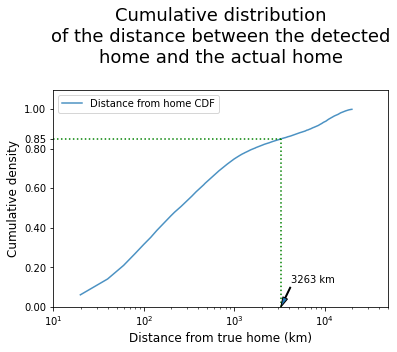

In [26]:
cumulative_dist_plot(df_distance_detection_from_truth.dist)

We see that to attain a 85% accuracy, we need to consider detected home locations to be true up to a distance of 3'263 km from the true home location. This distance almost as much as the distance from Beirut to Valencia, i.e. larger than the Mediterranean Sea.

Let us explore why this threshold distance is so large. We plot the distribution of distances on a log-log scale.

In [27]:
def power_func(x, a, b):
    """
    function to compute a*(x^b)
    """
    return a * np.power(x, b)

In [28]:
def density_loglog_dist_plot(series):
    fig = plt.figure()
    array = plt.hist(series, bins=1000, log=True, density=True, bottom=0, histtype='step')
    plt.close(fig)

    plt.loglog(array[1][1:], array[0], alpha=0.5, label='Distance from home probability density')
    
    start = 4
    
    distribution = array[0][start:]
    distances = array[1][start+1:]
    
    [a, b], _ = curve_fit(power_func, distances, distribution)
    
    x = range(round(distances[0]), round(distances[-1]))
    y = power_func(x, a, b)
    
    plt.loglog(x, y, color='r', label=r'$%.4f*x^{%.4f}$' % (a,b))
    
    plt.ylim(1e-6, 1e-2)
    plt.xlim(10, 5*1e4)
    
    plt.ylabel("Probability density", fontsize=12)
    plt.xlabel("Distance from true home (km)", fontsize=12)

    plt.title("Probability distribution\nof the distance between the detected\nhome and the actual home\n",
              fontsize=18)

    plt.legend()

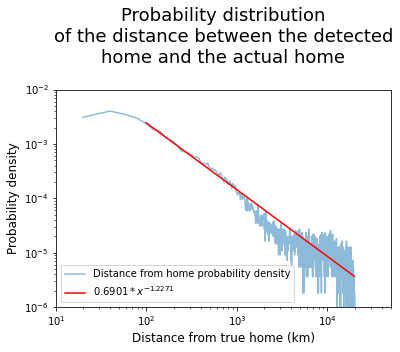

In [29]:
density_loglog_dist_plot(df_distance_detection_from_truth.dist)

### <span style="color:red">Percentiles and interpretation</span>